In [1]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
# from efficientnet_pytorch import EfficientNet


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
class Config:
    BATCH_SIZE = 32
    TRAINING_EPOCHS = 150
    VALIDATION_STEPS_PER_EPOCH = 5
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 5
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [3]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 0 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 1 # HE
        particle_energy = int(img_path.split('_')[8])
    return [img_path, particle_class, particle_energy]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy']

In [4]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)
er_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)

In [5]:
# TODO: Write this to a separate folder

# 0 - [:750]
# 1 - [750:1502]
# 0 - [1502:7531]
# 1 - [7531:]

import glob
private_test = glob.glob(str(PRIVATE_PATH / '**/*.png'), recursive=True)
public_test = glob.glob(str(PUBLIC_PATH / '**/*.png'), recursive=True)

sample_submission = pd.read_csv(INPUT_PATH / 'track1_leak.csv')
private_ids = [t.split('/')[-1].split('.')[0] for t in private_test]
public_ids = [t.split('/')[-1].split('.')[0] for t in public_test]

sample_submission['path'] = sample_submission['id'].apply(lambda x: PRIVATE_PATH / f'{x}.png' if x in private_ids else PUBLIC_PATH / f'{x}.png').map(str)
sample_submission.iloc[:750, 1] = 0
sample_submission.iloc[750:1502, 1] = 1
sample_submission.iloc[1502:7531, 1] = 0
sample_submission.iloc[7531:, 1] = 1

sample_submission = sample_submission.iloc[1502:].reset_index(drop = True)

images_leak = pd.DataFrame(np.array([sample_submission.iloc[:, 3].values, sample_submission.iloc[:, 1].values, sample_submission.iloc[:, 2].values]).T)
images_leak.columns = ['path', 'class', 'energy']

In [6]:
images = pd.concat([images, images_leak]).reset_index(drop = True)

In [7]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]
images = images.drop(index = test_idx)

# train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
# train_images = train_images.reset_index(drop = True)
# valid_images = valid_images.reset_index(drop = True)

train_images = images.copy()

In [8]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, is_classification = True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = np.zeros((self.batch_size, 150, 150, 3))
        y_class = np.zeros((self.batch_size,))
        y_energy = np.zeros((self.batch_size))
        for i, idx in enumerate(batch):
            image=cv2.imread(self.images.iloc[idx, 0])[225:375, 225:375, :]
            X[i,] = image
            
            if self.augment:
                X[i, ] = Config.train_transform(image=X[i,].astype(np.uint8))['image']
            particle_class = self.images.iloc[idx, 1]
            particle_energy = self.images.iloc[idx, 2]
            y_class[i] = particle_class
            y_energy[i] = particle_energy
        if self.is_classification:
            return X / 255.0, y_class
        return X / 255.0, y_energy


In [10]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, is_classification = True, augment = False)
valid_datagen = DataGenerator(images_leak, batch_size = Config.BATCH_SIZE, is_classification = True)
test_datagen = DataGenerator(test_images, batch_size = 1, is_classification = True, shuffle = False)

In [11]:
# Example data extract

X, y_class = train_datagen.__getitem__(0)

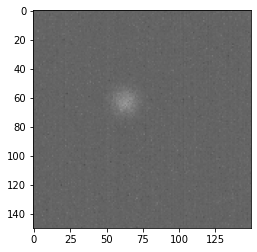

In [12]:
idx = 17
plt.imshow((X[idx] * 255).astype(np.uint8))

## Class model

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model = MobileNetV2(weights='imagenet', include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
from keras import layers as L
from keras.models import Model
import tensorflow as tf
import keras
import tensorflow

earlystop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10)
ckpt = keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / 'cnn_classification_best', save_best_only=True, monitor='val_auc', mode='max')
    
def create_classification_model(base_model):
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    #x = L.Dense(512, activation='relu')(x)
    x = L.Dense(128, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = L.Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-3), loss='binary_crossentropy', metrics = ['AUC'])
    return model

In [15]:
model = create_classification_model(base_model)

In [ ]:
model.fit(
    train_datagen, 
    steps_per_epoch = Config.STEPS_PER_EPOCH, 
    validation_data = valid_datagen, 
    validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
    epochs = Config.TRAINING_EPOCHS,
    verbose = 1,
    callbacks = [earlystop]
    )

Epoch 1/150
30/30 [==============================] - 29s 293ms/step - loss: 1.2494 - auc: 0.5499 - val_loss: 0.6426 - val_auc: 0.7484
Epoch 2/150
30/30 [==============================] - ETA: 0s - loss: 0.7062 - auc: 0.6428

In [181]:
model = keras.models.load_model(OUTPUT_PATH / 'models' / 'cnn_classification_best')

In [182]:
model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)

  4/117 [>.............................] - ETA: 7:15 - loss: 0.5827 - auc: 0.7419

KeyboardInterrupt: 

In [183]:
model.evaluate(test_datagen, batch_size=1, steps=test_images.shape[0])

12/12 [==============================] - 2s 127ms/step - loss: 0.7240 - auc: 0.5139


[0.7240045666694641, 0.5138888955116272]

In [74]:
model.predict_generator(test_datagen, steps=test_images.shape[0])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0.02620491],
       [0.60191727],
       [0.02053371],
       [0.5163692 ],
       [0.13396707],
       [0.66857994],
       [0.6708336 ],
       [0.90023726],
       [0.45335543],
       [0.7269842 ],
       [0.22088017],
       [0.63909924]], dtype=float32)

In [51]:
model.save(OUTPUT_PATH / 'models' / 'cnn_classification')